# Visualizations in Plotly for the DMP Aspect Test Experiment

In [1]:
%matplotlib notebook

In [2]:
import sys
sys.path.append("../../")

from dmp.data.logging import _get_sql_engine
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
from joblib import Memory
from ipywidgets import interact, interact_manual
import ipywidgets as widgets

import plotly.graph_objects as go

In [3]:
import scipy
import scipy.interpolate

In [12]:
db = _get_sql_engine()

memory = Memory(location="./cache", verbose=0)

def query(query_string):
    with db.connect() as engine:
        return pd.read_sql(query_string, engine)

cached_query = memory.cache(query)

def clear_cache():
    memory.clear()
    
options = {
    "dataset": ['529_pollen',
        'sleep',
#         'adult',
        '537_houses',
#         'nursery',
        '201_pol',
        'mnist',
        'connect_4',
        'wine_quality_white'],
    "agg": ["avg", "min", "max"],
    "topology" : ["exponential", "rectangle", "trapezoid", "wide_first"],
    "loss": ['history_loss', 'history_hinge', 'history_accuracy',
       'history_val_loss', 'history_val_hinge', 'history_val_accuracy',
       'history_squared_hinge', 'history_cosine_similarity',
       'history_val_squared_hinge', 'history_mean_squared_error',
       'history_mean_absolute_error', 'history_val_cosine_similarity',
       'history_val_mean_squared_error', 'history_root_mean_squared_error',
       'history_val_mean_absolute_error',
       'history_kullback_leibler_divergence',
       'history_val_root_mean_squared_error',
       'history_mean_squared_logarithmic_error',
       'history_val_kullback_leibler_divergence',
       'history_val_mean_squared_logarithmic_error'],
    "residual_mode": ["none", "full"],
    "group_select" : ["min", "max"],
    'depth':[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
    'budget': [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384,
                32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304,
                8388608, 16777216, 33554432],
    'color_range': (1.01, 10.0, .01),
    'epoch_axis' : ['epoch', 'log_effort', 'effort']
    
}

import plotly.io as pio
pio.templates["dmp_template"] = go.layout.Template(
    layout=go.Layout(
        colorscale={
            'diverging':'Temps',
            'sequential': 'Viridis_r',
            'sequentialminus':'Viridis_r',
#             'sequential': 'Agsunset_r',
#             'sequentialminus':'Agsunset_r',
        }
    )
)
pio.templates.default = 'dmp_template'

In [5]:
clear_cache()

In [6]:
def setup_value(df, loss, color_range):
    z_label = loss
    #     df["value"] = -np.log(np.minimum(df["value"], np.min(df["value"])*4))   
#     df["value"] = -np.log(df['value'] / np.min(df['value']))
#     df["value"] = -np.log(df['value'] / np.min(df['value']))
#     df["value"] = -(df['value'] / np.min(df['value']))

    minimizing = True
    if 'accuracy' in loss:
        df['value'] = 1 - df['value']
        df['value'] = np.minimum(np.min(df['value']) * color_range, df['value'])
        df["value"] = np.log(df['value'])/np.log(10)
        z_label = f'log(1-{loss})'
    elif 'loss' in loss:
#         df["value"] = -np.exp(1 - df['value']/np.min(df['value']))
        df['value'] = np.minimum(np.min(df['value']) * color_range, df['value'])
#         df["value"] = -np.log(df['value'])/np.log(10)
#         z_label = f'-log({loss})'
        
        df["value"] = df['value'] / np.abs(np.min(df['value']))
        z_label = f'loss / abs(min(loss))'
#         df["value"] = -np.log(df['value'] / np.min(df['value']))/np.log(10)
#         df["value"] = -df['value'] / np.min(df['value'])
    elif 'error' in loss:
        df["value"] = df['value'] / np.min(df['value'])
        df['value'] = np.minimum(color_range, df['value'])
        z_label = f'error / min(error)'
    
    if minimizing:
        best = np.nanmin(df['value'])
    else:
        best = np.nanmax(df['value'])
        
    return z_label, minimizing, best

def compute_effort(df):
    df["effort"] = (df["epoch"] * df["config.budget"].astype("float")).astype("float")
    df["log_effort"] = np.log(df["effort"]) / np.log(10)
    df['relative_effort'] = df['effort'] / np.min(df['effort'])
    df['relative_log_effort'] = np.log(df['relative_effort']) / np.log(10)


def get_values_for_categorical_keys(df, partition_keys):
    partitions = []
    for partition_key in partition_keys:
        partition_values = sorted(df[partition_key].unique())
        partitions.append(
            (partition_key,
            {key : index for index, key in enumerate(partition_values)},
            partition_values
            ))
    return tuple(partitions)

def partitioned_interpolation(df, partition_keys, interpolation_key, value_key, resolution):
    partitions = get_values_for_categorical_keys(df, partition_keys)
    
    def make_partition_accumulator(i):
        index = partitions[i][1]
        return [make_partition_accumulator(i + 1) if i < len(partitions) - 1 else ([], []) 
                for p in range(len(index))]
    acc = make_partition_accumulator(0)
    
    for _, row in df.iterrows():
        a = acc
        for partition_key, index, _ in partitions:
            a = a[index[row[partition_key]]]
        a[0].append(row[interpolation_key])
        a[1].append(row[value_key])

    interpolation_series = df[interpolation_key]
    interpolation_index = np.linspace(np.min(interpolation_series), np.max(interpolation_series), resolution)
    partition_indexes = [np.linspace(0, len(p), len(p)) for p in partitions]
    
    def do_interpolation(a):
        if type(a) is list:
            return [do_interpolation(p) for p in a]
        func = scipy.interpolate.interp1d(a[0], a[1], kind='linear', bounds_error=False, fill_value=np.NaN)
        return func(interpolation_index)            
    interpolated = np.array(do_interpolation(acc))
    print(f'interpolated {interpolated.shape}')
    return partitions, interpolation_index, interpolated


def make_2d_heatmap_viz(df, groups, dataset, topology, loss, agg, residual_mode, viz, color_range):
    z_label, minimizing, best = setup_value(df, loss, color_range)
        
    if viz == "imshow":
        img = df.pivot_table(columns="epoch", index="config.budget", values="value")
        fig = px.imshow(img)
        fig.update_yaxes(type='category')
    elif viz == "scatter":
        df = df.sort_values(["epoch", "config.budget"], ascending=[True, False])
        df["config.budget"] = df["config.budget"].astype("str")
        df["epoch"] = df["epoch"].astype("str")
        fig = px.scatter(df, x="epoch", y="config.budget", size="count", color="value")
    elif viz == "effort":
        compute_effort(df)
        key = 'log_effort'
        x_res = 4000
        partitions, x_index, interpolated = partitioned_interpolation(df, ['config.budget'], key, 'value', x_res)
        fig= px.imshow(interpolated, aspect='auto', zmin=np.min(interpolated), zmax=np.max(interpolated),
            x = x_index,
            y = [str(b) for b in partitions[0][1]],
            labels=dict(x="log(Effort)", y="# Parameters", color=z_label),)
        fig.update_yaxes(type='category')
    else:
        return None
    fig.update_layout(title=f"{z_label} using {loss} for {dataset}, {topology}, residual {residual_mode}")
    return fig


# 3D Heatmap App

In [7]:
@interact_manual(**options, viz=["volume", "scatter"])
def heatmap_app_3d(groups="('fixed_01')", dataset="201_pol", topology="trapezoid", loss="history_val_loss", agg="avg", residual_mode="none", viz="volume", epoch_axis = 'epoch', color_range=1.25):
    query_string = f'''
    select "config.budget", "config.depth", {agg}(a.val) as value, count(a.val), a.epoch
    from
        materialized_experiments_0 t,
        unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
    WHERE
        "groupname" IN {groups} and
        "config.dataset"='{dataset}' and
        "config.topology"='{topology}' and
        "config.residual_mode"='{residual_mode}'
    GROUP BY epoch, "config.budget", "config.depth"
    ORDER BY epoch, "config.budget", "config.depth"
    '''
    df = cached_query(query_string).query("count >= 7")    
    value_label, minimizing, best = setup_value(df, loss, color_range)    
    if 'effort' in epoch_axis:
        compute_effort(df)        
    
    if viz=="scatter":        
        return px.scatter_3d(df,
                    x='config.depth',
                    y='config.budget',
                    z=epoch_axis,
                    color='value',
                    log_y=True,
                    opacity=0.25)
    elif viz == "volume":
        x_res = 2000
        partition_keys = ['config.budget', 'config.depth']
        
        if 'effort' in epoch_axis:
            partitions, z_index, values = partitioned_interpolation(df, partition_keys, epoch_axis, 'value', x_res)
        else:
            partition_keys.append(epoch_axis)
            partitions = get_values_for_categorical_keys(df, partition_keys)
            z_index = np.array(list(partitions[2][1].keys()))
            values = np.empty((len(partitions[0][2]), len(partitions[1][2]), len(partitions[2][2])))
            values[:] = np.NaN
            for _, row in df.iterrows():
                values[partitions[0][1][row[partition_keys[0]]], 
                       partitions[1][1][row[partition_keys[1]]], 
                       partitions[2][1][row[partition_keys[2]]]] = row['value']
        
        max_value = np.nanmax(values)
        values = np.nan_to_num(values, copy=False, nan=max_value + 1e-12) # set NaNs to just over the max value
        
        # trim data to the visible range
        z_start = next((z for z in range(values.shape[2]) if np.any(values[:,:,z] < max_value)), 0)
        z_end = next((z for z in reversed(range(values.shape[2])) if np.any(values[:,:,z] < max_value))
                     , values.shape[2])
        values = values[:,:,z_start:z_end+1]
        z_index = z_index[z_start:z_end+1]
            
        print(f'value: {np.nanmin(values)} {np.nanmax(values)} z_start {z_start} z_end {z_end}')
        mesh = [dim.flatten() for dim in np.meshgrid(
            np.array(range(len(partitions[0][2]))),
            np.array(range(len(partitions[1][2]))),
            z_index,            
            indexing='ij'
            )]
        print(f'{np.min(mesh[0])} {np.max(mesh[0])} {np.min(mesh[1])} {np.max(mesh[1])} {np.min(mesh[2])} {np.max(mesh[2])}')
        fig = go.Figure(data=go.Volume(
            x=mesh[0],
            y=mesh[1],
            z=mesh[2],
            value=values.flatten(),
            opacity=1.0,
            isomin= np.nanmin(values),
            isomax= max_value - 1e-12,
            caps= dict(x_show=False, y_show=False, z_show=False),
            surface_count=5,
            opacityscale="min",
            colorscale="YlOrRd_r"
            ))
        
        print(z_index[0], z_index[-1])

        axis_data = [dict(ticktext=p[2],
                         tickvals=list(range(len(p[2]))),
                         title=p[0]) 
                     for p in partitions]

        fig.update_layout(
            scene = dict(
                xaxis = axis_data[0],
                yaxis = axis_data[1],
                zaxis = dict(
                    nticks = 10,
                    range=[z_index[0], z_index[-1]],
                    title=epoch_axis
                )
            ),
            width=950, height=950,
            title=f"{value_label} using {loss} for {dataset}, {topology}, residual {residual_mode}",
            )
        return fig



interactive(children=(Text(value="('fixed_01')", description='groups'), Dropdown(description='dataset', index=…

In [9]:
@interact_manual(**options, viz=["volume", "scatter"])
def heatmap_app_3d(groups="('fixed_01')", dataset="201_pol", topology="trapezoid", loss="history_val_loss", agg="avg", residual_mode="none", viz="volume", epoch_axis = 'epoch', color_range=1.25):
    query_string = f'''
    select "config.budget", "config.depth", {agg}(a.val) as value, count(a.val), a.epoch
    from
        materialized_experiments_0 t,
        unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
    WHERE
        "groupname" IN {groups} and
        "config.dataset"='{dataset}' and
        "config.topology"='{topology}' and
        "config.residual_mode"='{residual_mode}'
    GROUP BY epoch, "config.budget", "config.depth"
    ORDER BY epoch, "config.budget", "config.depth"
    '''
    df = cached_query(query_string).query("count >= 7")    
    value_label, minimizing, best = setup_value(df, loss, color_range)    
    if 'effort' in epoch_axis:
        compute_effort(df)        
    
    if viz=="scatter":        
        return px.scatter_3d(df,
                    x='config.depth',
                    y='config.budget',
                    z=epoch_axis,
                    color='value',
                    log_y=True,
                    opacity=0.25)
    elif viz == "volume":
        x_res = 2000
        partition_keys = ['config.budget', 'config.depth']
        
        if 'effort' in epoch_axis:
            partitions, z_index, values = partitioned_interpolation(df, partition_keys, epoch_axis, 'value', x_res)
        else:
            partition_keys.append(epoch_axis)
            partitions = get_values_for_categorical_keys(df, partition_keys)
            z_index = np.array(list(partitions[2][1].keys()))
            values = np.empty((len(partitions[0][2]), len(partitions[1][2]), len(partitions[2][2])))
            values[:] = np.NaN
            for _, row in df.iterrows():
                values[partitions[0][1][row[partition_keys[0]]], 
                       partitions[1][1][row[partition_keys[1]]], 
                       partitions[2][1][row[partition_keys[2]]]] = row['value']
        
        max_value = np.nanmax(values)
        values = np.nan_to_num(values, copy=False, nan=max_value + 1e-12) # set NaNs to just over the max value
        
        # trim data to the visible range
        z_start = next((z for z in range(values.shape[2]) if np.any(values[:,:,z] < max_value)), 0)
        z_end = next((z for z in reversed(range(values.shape[2])) if np.any(values[:,:,z] < max_value))
                     , values.shape[2])
        values = values[:,:,z_start:z_end+1]
        z_index = z_index[z_start:z_end+1]
            
        print(f'value: {np.nanmin(values)} {np.nanmax(values)} z_start {z_start} z_end {z_end}')
        mesh = [dim.flatten() for dim in np.meshgrid(
            np.array(range(len(partitions[0][2]))),
            np.array(range(len(partitions[1][2]))),
            z_index,            
            indexing='ij'
            )]
        print(f'{np.min(mesh[0])} {np.max(mesh[0])} {np.min(mesh[1])} {np.max(mesh[1])} {np.min(mesh[2])} {np.max(mesh[2])}')
        fig = go.Figure(data=go.Volume(
            x=mesh[0],
            y=mesh[1],
            z=mesh[2],
            value=values.flatten(),
            opacity=1.0,
            isomin= np.nanmin(values),
            isomax= max_value - 1e-12,
            caps= dict(x_show=False, y_show=False, z_show=False),
            surface_count=5,
            opacityscale="min",
            colorscale="YlOrRd_r"
            ))
        
        print(z_index[0], z_index[-1])

        axis_data = [dict(ticktext=p[2],
                         tickvals=list(range(len(p[2]))),
                         title=p[0]) 
                     for p in partitions]

        fig.update_layout(
            scene = dict(
                xaxis = axis_data[0],
                yaxis = axis_data[1],
                zaxis = dict(
                    nticks = 10,
                    range=[z_index[0], z_index[-1]],
                    title=epoch_axis
                )
            ),
            width=950, height=950,
            title=f"{value_label} using {loss} for {dataset}, {topology}, residual {residual_mode}",
            )
        return fig



interactive(children=(Text(value="('fixed_01')", description='groups'), Dropdown(description='dataset', index=…

In [9]:
@interact_manual(**options, 
                 statistic=["epoch", "effort", "log_effort", 'relative_effort', 'relative_log_effort', 'relative_log_effort_to_minimize', 'best'], 
                 viz=['imshow', 'depth_lines', 'budget_lines'],
                 depths=widgets.IntRangeSlider(min=2, max=20, step=1, value=(2,20)))
def heatmap_app(groups="('fixed_01')", dataset="201_pol", topology="trapezoid", loss="history_val_loss", agg="avg", residual_mode="none", statistic = 'relative_log_effort', color_range=1.10, viz='imshow'):
    query_string = f'''
    select "config.budget", "config.depth", {agg}(a.val) as value, count(a.val), a.epoch
    from
        materialized_experiments_0 t,
        unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
    WHERE
        "groupname" IN {groups} and
        "config.dataset"='{dataset}' and
        "config.topology"='{topology}' and
        "config.residual_mode"='{residual_mode}'
    GROUP BY epoch, "config.budget", "config.depth"
    ORDER BY epoch, "config.budget", "config.depth"
    '''
    df = cached_query(query_string).query("count >= 7")    
#     z_label, minimizing, best = setup_value(df, loss, color_range)    
        
#     if viz=="efficiency":        
#         z_label = setup_value(df, loss, color_range)
    partition_keys = ['config.depth', 'config.budget']
    partitions = get_values_for_categorical_keys(df, partition_keys)
    
    filtered = df
    if statistic != 'relative_log_effort_to_minimize':
        best = np.nanmin(filtered['value']) # find best value
        threshold = best * color_range
        filtered = filtered[filtered['value'] <= threshold]
            
    minimize = 'epoch'
    select = 'epoch'
    if statistic == 'relative_log_effort_to_minimize':
        minimize = 'value'
    elif statistic == 'best':
        minimize = 'value'
        select = 'value'

    def find_first_epoch(group):
        return group.sort_values(minimize).iloc[0][select]

    composite = filtered.groupby(partition_keys).apply(find_first_epoch).reset_index(name=select)

    z_label = statistic
    if statistic == 'best':
        z_label, minimizing, best = setup_value(composite, loss, color_range)
        composite[statistic] = composite[select] / np.min(composite[select])
    else:
        compute_effort(composite)
        if statistic == 'relative_log_effort_to_minimize':
            composite['relative_log_effort_to_minimize'] = composite['relative_log_effort']
    
    color_continuous_scale = 'Greens_r'
    if statistic in ['epoch']:
        color_continuous_scale = 'Sunsetdark'

    if viz == 'imshow':
        x_key = 'config.depth'
        y_key = 'config.budget'
        img = composite.pivot_table(columns=x_key, index=y_key, values=statistic)
        fig = px.imshow(img, color_continuous_scale=color_continuous_scale,
                       labels=dict(x=x_key, y=y_key, color=z_label))
        axis_data = [dict(
            categoryorder='array',
            categoryarray=p[2],
            title=p[0],
            type='category') 
            for p in partitions]    
        fig.update_layout(
            xaxis = axis_data[0],
            yaxis = axis_data[1],
            title=f'{dataset}, {topology}, residual {residual_mode}<br>{statistic} to reach {"{:.2f}".format(100*(color_range-1))}% of best {loss}',
#             coloraxis=dict(
#                 title=statistic
#                 )
            coloraxis_colorbar_x=.7,
            )
    elif viz == 'depth_lines':
        fig = px.line(composite, x='config.budget', y=statistic, color='config.depth', log_x=True)
        
    elif viz == 'budget_lines':
        fig = px.line(composite, x='config.depth', y=statistic, color='config.budget')
    return fig



interactive(children=(Text(value="('fixed_01')", description='groups'), Dropdown(description='dataset', index=…

# 2D Heatmap App

In [16]:
### Heapmap App using Imshow

@interact_manual(**options, 
                 viz=["imshow", "scatter", "effort"], 
                 depths=widgets.IntRangeSlider(min=2, max=20, step=1, value=(2,20)))
def heatmap_app(
    groups="('fixed_3k_0')", 
    dataset="529_pollen", 
    topology="wide_first", 
    loss="history_val_loss", 
    agg="avg",
    residual_mode="none", 
    viz="effort", 
    depths=(2,20),
    color_range=1.3):
    
    query_string = f'''
select "config.budget", {agg}(a.val) as value, count(a.val), a.epoch
from
    materialized_experiments_0 t,
    unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
WHERE
    "groupname" IN {groups} and
    "config.dataset"='{dataset}' and
    "config.topology"='{topology}' and
    "config.residual_mode"='{residual_mode}' and
    "config.depth" BETWEEN {depths[0]} and {depths[1]}
GROUP BY epoch, "config.budget"
'''
    df = cached_query(query_string)
    return make_2d_heatmap_viz(df, groups, dataset, topology, loss, agg, residual_mode, viz, color_range)

interactive(children=(Text(value="('fixed_3k_0')", description='groups'), Dropdown(description='dataset', opti…

In [16]:
### Heapmap App using Imshow

@interact_manual(**options, 
                 viz=["imshow", "scatter", "effort"])
def heatmap_app(
    groups="('fixed_01')", 
    dataset="529_pollen", 
    topology="wide_first", 
    loss="history_val_loss", 
    agg="avg",
    residual_mode="none", 
    viz="effort", 
    depth=3,
    color_range=4.0):
    
    query_string = f'''
select "config.budget", {agg}(a.val) as value, count(a.val), a.epoch
from
    materialized_experiments_0 t,
    unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
WHERE
    "groupname" IN {groups} and
    "config.dataset"='{dataset}' and
    "config.topology"='{topology}' and
    "config.residual_mode"='{residual_mode}' and
    "config.depth" = {depth}
GROUP BY epoch, "config.budget"
'''
    df = cached_query(query_string)
    return make_2d_heatmap_viz(df, groups, dataset, topology, loss, agg, residual_mode, viz, color_range)

interactive(children=(Text(value="('fixed_01')", description='groups'), Dropdown(description='dataset', option…

In [17]:
### Heapmap App using Imshow

@interact_manual(**options, 
                 viz=["imshow", "scatter", "effort"], 
                 depths=widgets.IntRangeSlider(min=2, max=20, step=1, value=(2,20)))
def heatmap_app(
    groups="('fixed_01')", 
    dataset="sleep", 
    topology="rectangular", 
    loss="history_val_loss", 
    agg="avg",
    group_select="min",
    residual_mode="none", 
    viz="effort", 
    depths=(2,20),
    color_range=1.25):    
    group_direction = 'asc' if group_select == 'min' else 'desc'        
    query_string = f'''
SELECT min_groups."config.budget", min_groups."config.depth", count(*), {agg}(a.value) AS value, a.epoch as epoch
FROM
    (SELECT "config.budget", "config.depth"
     FROM
        (SELECT "config.budget", "config.depth",
               ROW_NUMBER() OVER(PARTITION BY min_values."config.budget" ORDER BY {agg}(min_value) {group_direction}) AS rank
        FROM
            (SELECT "config.budget", "config.depth", t.id AS id, {group_select}(a.val) AS min_value
            FROM
                materialized_experiments_0 t,
                unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
            WHERE
             t."groupname" IN {groups} and
             t."config.dataset"='{dataset}' and
             t."config.topology"='{topology}' and
             t."config.residual_mode"='{residual_mode}' and
             t."config.depth" BETWEEN {depths[0]} and {depths[1]}
            GROUP BY "config.budget", "config.depth", t.id) AS min_values
        GROUP BY "config.budget", "config.depth") AS min_groups
        WHERE rank = 1) as min_groups,
    materialized_experiments_0 as t,
    unnest(t.{loss}) WITH ORDINALITY as a(value, epoch)
WHERE
    min_groups."config.budget" = t."config.budget" AND
    min_groups."config.depth" = t."config.depth" AND
    t."groupname" IN {groups} and
    t."config.dataset"='{dataset}' and
    t."config.topology"='{topology}' and
    t."config.residual_mode"='{residual_mode}' and
    t."config.depth" BETWEEN {depths[0]} and {depths[1]}
GROUP BY min_groups."config.budget", min_groups."config.depth", a.epoch;
'''
    df = cached_query(query_string)
    fig = make_2d_heatmap_viz(df, groups, dataset, topology, loss, agg, residual_mode, viz, color_range)
    return fig

interactive(children=(Text(value="('fixed_01')", description='groups'), Dropdown(description='dataset', index=…

In [17]:
### Heapmap App using Imshow

@interact_manual(**options, 
                 viz=["imshow", "scatter", "effort"], 
                 depths=widgets.IntRangeSlider(min=2, max=20, step=1, value=(2,20)))
def heatmap_app(
    groups="('fixed_01')", 
    dataset="529_pollen", 
    topology="wide_first", 
    loss="history_val_loss", 
    agg="avg",
    group_select="min",
    residual_mode="none", 
    viz="effort", 
    depths=(2,20),
    color_range=4.0):    
    group_direction = 'asc' if group_select == 'min' else 'desc'        
    query_string = f'''
SELECT min_groups."config.budget", min_groups."config.depth", count(*), {agg}(a.value) AS value, a.epoch as epoch
FROM
    (SELECT "config.budget", "config.depth"
     FROM
        (SELECT "config.budget", "config.depth",
               ROW_NUMBER() OVER(PARTITION BY min_values."config.budget" ORDER BY {agg}(min_value) {group_direction}) AS rank
        FROM
            (SELECT "config.budget", "config.depth", t.id AS id, {group_select}(a.val) AS min_value
            FROM
                materialized_experiments_0 t,
                unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
            WHERE
             t."groupname" IN {groups} and
             t."config.dataset"='{dataset}' and
             t."config.topology"='{topology}' and
             t."config.residual_mode"='{residual_mode}' and
             t."config.depth" BETWEEN {depths[0]} and {depths[1]}
            GROUP BY "config.budget", "config.depth", t.id) AS min_values
        GROUP BY "config.budget", "config.depth") AS min_groups
        WHERE rank = 1) as min_groups,
    materialized_experiments_0 as t,
    unnest(t.{loss}) WITH ORDINALITY as a(value, epoch)
WHERE
    min_groups."config.budget" = t."config.budget" AND
    min_groups."config.depth" = t."config.depth" AND
    t."groupname" IN {groups} and
    t."config.dataset"='{dataset}' and
    t."config.topology"='{topology}' and
    t."config.residual_mode"='{residual_mode}' and
    t."config.depth" BETWEEN {depths[0]} and {depths[1]}
GROUP BY min_groups."config.budget", min_groups."config.depth", a.epoch;
'''
    df = cached_query(query_string)
    return make_2d_heatmap_viz(df, groups, dataset, topology, loss, agg, residual_mode, viz, color_range)

interactive(children=(Text(value="('fixed_01')", description='groups'), Dropdown(description='dataset', option…

In [14]:
# what depth is best for a given budget and toplogy?

@interact_manual(**options, 
                 viz=["imshow", "scatter", "effort"])
def heatmap_app(
    groups="('fixed_01')", 
    dataset="201_pol", 
    topology="trapezoid", 
    loss="history_val_loss", 
    agg="avg",
    residual_mode="none", 
    viz="effort", 
    budget=8192,
    color_range=1.1):
    
    query_string = f'''
select "config.depth", "config.budget", {agg}(a.val) as value, count(a.val), a.epoch
from
    materialized_experiments_0 t,
    unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
WHERE
    "groupname" IN {groups} and
    "config.dataset"='{dataset}' and
    "config.topology"='{topology}' and
    "config.residual_mode"='{residual_mode}' and
    "config.budget" = {budget}
GROUP BY "config.depth", "config.budget", epoch
'''
    df = cached_query(query_string)
    
    
    z_label = setup_value(df, loss, color_range)
    x_key = 'epoch'
    y_key = 'config.depth'
    img = df.pivot_table(columns="epoch", index="config.depth", values="value")
    img.index = img.index.astype("str") #plotly interprets the y axis as numeric otherwise
    fig = px.imshow(img)
    fig.update_yaxes(type='category')
    return fig

interactive(children=(Text(value="('fixed_01')", description='groups'), Dropdown(description='dataset', index=…

In [ ]:

# plot a line for each depth across budgets for a specific topology - best value? 
# plot a line for each topology across budgets for a specific depth, or the best depth
    

## Choose Your Axis Heatmap Plot

In [59]:
### Heapmap App using Imshow

axis = ["dataset", "topology", "residual_mode", "budget"]

@interact_manual(**options, viz=["imshow", "scatter"], y_dim=axis)
def heatmap_app(groups="('fixed_01')", x_dim="epoch", y_dim="budget", budget="64", dataset="537_houses", topology="wide_first", loss="history_val_mean_squared_error", agg="avg", residual_mode="none", viz="imshow"):
    axis = ["dataset", "topology", "residual_mode", "budget"]
    args = locals()
    filter_string = " and ".join([f'''"config.{s}"='{args[s]}' ''' for s in axis if s != y_dim])
    query_string = f'''
select "config.{y_dim}", {agg}(a.val) as value, count(a.val), a.epoch
from
    materialized_experiments_0 t,
    unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
WHERE
    "groupname" IN {groups} and
    {filter_string}
GROUP BY {x_dim}, "config.{y_dim}"
'''
    df = cached_query(query_string)
    
    if viz == "imshow":
        #df = df.query("count > 389")
        img = df.pivot_table(columns=x_dim, index="config."+y_dim, values="value")
        img.index = img.index.astype("str") #plotly interprets the y axis as numeric otherwise
        return px.imshow(img)
    elif viz == "scatter":
        df = df.sort_values(["epoch", "config.budget"], ascending=[True, False])
        df["config.budget"] = df["config.budget"].astype("str")
        df["epoch"] = df["epoch"].astype("str")
        return px.scatter(df, x="epoch", y="config.budget", size="count", color="value")

interactive(children=(Text(value="('fixed_01')", description='groups'), Text(value='epoch', description='x_dim…

# Line Plot for Single budget x dataset x topology

In [ ]:
### single run app

@interact(**options)
def heatmap_app(dataset="537_houses", topology="wide_first", loss="history_val_mean_squared_error", agg="avg", residual_mode="none",
               budget="256"):
    query_string = f'''
select a.val as value, a.epoch, run_name
from
    materialized_experiments_0 t,
    unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
WHERE
    "groupname" IN ('exp00', 'exp01') and
    "config.dataset"='{dataset}' and
    "config.topology"='{topology}' and
    "config.residual_mode"='{residual_mode}' and
    "config.budget"='{budget}'
'''
    df = cached_query(query_string)
    return px.line(df, x="epoch", y="value", color="run_name")

##

- 537 houses, (val) kl divergence, trapezoid
- sleep, trapezoid, history_val_loss, 16777216

Notes:
- Logarithmic color map
- look into why sleep runs crash for high budgets
- plateau effect
- review stopping configurations / what is reasonable number of iterations?

# Next Steps

## Look at "plateau" feature from Charle's notebooks
## Add dataset, dataset complexity, as axis
## Add topology as an axis
### learning rate / optimizers / other axis to add

# To re-run using fixed epoch length, how long is reasonable?

In [ ]:
### Heapmap App using Imshow

@interact_manual(**options, viz=["imshow", "scatter"])
def heatmap_app(groups="('exp00', 'exp01')", dataset="537_houses", topology="wide_first", residual_mode="none", viz="imshow"):
    query_string = f'''
select
    "config.budget",
    avg(array_length(t.history_loss, 1)) as avg,
    min(array_length(t.history_loss, 1)) as min,
    max(array_length(t.history_loss, 1)) as max,
    stddev(array_length(t.history_loss, 1)) as std
from
    materialized_experiments_0 t
WHERE
    "groupname" IN {groups} and
    "config.dataset"='{dataset}' and
    "config.topology"='{topology}' and
    "config.residual_mode"='{residual_mode}'
GROUP BY "config.budget"
'''
    df = cached_query(query_string).sort_values("config.budget")
    
    return px.line(df, x="config.budget", y="avg", error_y="std", log_x=True)

In [ ]:
### Epoch Count App

@interact_manual(**options, viz=["imshow", "scatter"])
def epoch_count_app(groups="('exp00', 'exp01')", dataset="537_houses", topology="wide_first", residual_mode="none", viz="imshow"):
    query_string = f'''
select
    "config.budget",
    array_length(t.history_loss, 1) as num_epochs
from
    materialized_experiments_0 t
WHERE
    "groupname" IN {groups} and
    "config.dataset"='{dataset}' and
    "config.topology"='{topology}' and
    "config.residual_mode"='{residual_mode}'
'''
    df = cached_query(query_string)
    df = df.sort_values("config.budget")
    df["config.budget"] = df["config.budget"].astype("str")
    
    return px.scatter(df, x="config.budget", y="num_epochs", title=f"Number of epochs for {dataset}, {topology} in {groups}")

In [ ]:
### Epoch Count App

@interact_manual(**options, viz=["imshow", "scatter"])
def epoch_count_app(groups="('exp00', 'exp01')", dataset="537_houses", topology="wide_first", residual_mode="none", viz="imshow"):
    query_string = f'''
select
    "config.budget",
    "config.topology",
    array_length(t.history_loss, 1) as num_epochs
from
    materialized_experiments_0 t
WHERE
    "groupname" IN {groups} and
    "config.dataset"='{dataset}' and
    "config.residual_mode"='{residual_mode}'
'''
    df = cached_query(query_string).sort_values("config.budget")
    
    df["config.budget"] = df["config.budget"].astype("str")
    
    return px.violin(df,
                    x="config.budget",
                    y="num_epochs",
                    color="config.topology",
                     box=True,
                    title=f"Number of epochs for {dataset}, in {groups}")

In [ ]:
### Epoch Count App

@interact_manual(**options, viz=["imshow", "scatter"])
def epoch_count_agg_app(groups="('exp00', 'exp01')", dataset="537_houses", topology="wide_first", residual_mode="none", viz="imshow"):
    query_string = f'''
select
    "config.budget",
    "config.dataset",
    array_length(t.history_loss, 1) as num_epochs
from
    materialized_experiments_0 t
WHERE
    "groupname" IN {groups} and
    "config.topology"='{topology}' and
    "config.residual_mode"='{residual_mode}'
'''
    df = cached_query(query_string).sort_values("config.budget")
    
    df["config.budget"] = df["config.budget"].astype("str")
    
    return px.violin(df,
                    x="config.budget",
                    y="num_epochs",
                    color="config.dataset",
                     box=True,
                    title=f"Number of epochs for {topology}, in {groups}")

In [ ]:
### Generate 90th percentile epoch length for each experiment
query_string = f'''
select
    (percentile_disc(0.9) within group (order by array_length(t.history_loss, 1))) as epoch_90_pctile,
    "config.topology",
    "config.residual_mode",
    "config.dataset",
    "config.budget"
FROM
    materialized_experiments_0 t
WHERE
    "groupname" IN ('exp00','exp01')
GROUP BY
    "config.topology",
    "config.residual_mode",
    "config.dataset",
    "config.budget"
'''

df = cached_query(query_string)

df

In [ ]:
### Generate 90th percentile epoch length for each experiment
query_string = f'''
    select
        max(array_length(t.history_loss, 1)) as epoch_max,
        (percentile_disc(0.90) within group (order by array_length(t.history_loss, 1))) as epoch_90_pctile,
        "config.topology",
        "config.residual_mode",
        "config.dataset",
        "config.budget"
    FROM
        materialized_experiments_0 t
    WHERE
        "groupname" IN ('exp00','exp01')
    GROUP BY
        "config.topology",
        "config.residual_mode",
        "config.dataset",
        "config.budget"
'''

df = cached_query(query_string)

df

In [ ]:
df2 = df.groupby(["config.topology", "config.residual_mode", "config.dataset"]).max().drop("config.budget", axis=1)

df2.to_csv("epoch_90th_pctile.csv")
df2

In [ ]:
df.to_csv("epoch_90th_pctile_each_budget.csv")

In [ ]:
## Now, we want to add dataset (or some statistic derived from the dataset's complexity) and topology as axis.

In [ ]:
df = cached_query('''select * from materialized_experiments_0 WHERE "groupname" IN ('exp04') limit 10''')
display(df.columns)
df

In [ ]:
# Plot the heatmap of validation loss for one topology, one dataset, over iteration count and different budgets

q = '''
select "config.budget", avg(a.val) as val_loss, avg(a.loss) as train_loss, count(a.loss), a.epoch
from
    materialized_experiments_0 t,
    unnest(t.history_val_mean_squared_error, t.history_mean_squared_error) WITH ORDINALITY as a(val, loss, epoch)
WHERE
    "groupname" IN ('exp00', 'exp01') and
    "config.dataset"='537_houses' and
    "config.topology"='wide_first' and
    "config.residual_mode"='none'
GROUP BY epoch, "config.budget"
'''

# q = '''
# select distinct("name")
# from
#     materialized_experiments_0
# WHERE
#     "groupname" IN ('exp00', 'exp01') and
#     "config.dataset"='537_houses' and
#     "config.topology"='wide_first' and
#     "config.residual_mode"='none' and
#     "config.budget"=262144
# limit 10
# '''

df = cache_query(q)
display(df.columns)
df

In [10]:
### Generate max of 95th percentile epoch length and iterations to smallest loss over all topologies for each budget and dataset
query_string = f'''
select max(max_iterations) as max_iterations,
       max(p95) as p95,
       max(p90) as p90,
       max(p67) as p67,
       max(p50) as p50,
       max(p33) as p33,
       max(avg_iterations) as avg_iterations,
       max(foo.max_patience) as max_patience,
       min(foo.min_patience) as min_patience,
    foo."config.dataset",
    foo."config.budget"
--    foo."config.topology",
--    foo."config.residual_mode"
FROM
    (SELECT
        MAX(iterations) as max_iterations,
        (percentile_disc(0.95) within group (order by iterations ASC)) as p95,
        (percentile_disc(0.9) within group (order by iterations ASC)) as p90,
        (percentile_disc(0.67) within group (order by iterations ASC)) as p67,
        (percentile_disc(0.5) within group (order by iterations ASC)) as p50,
        (percentile_disc(0.33) within group (order by iterations ASC)) as p33,
        AVG(iterations) as avg_iterations,
        max("config.early_stopping.patience") as max_patience,
        min("config.early_stopping.patience") as min_patience,
        "config.topology",
        "config.residual_mode",
        "config.dataset",
        "config.budget",
        "config.depth"
    FROM
        materialized_experiments_0 t
    WHERE
        "groupname" IN ('exp00','exp01')
    GROUP BY
        "config.topology",
        "config.residual_mode",
        "config.dataset",
        "config.budget",
        "config.depth") AS foo
    GROUP BY
        foo."config.dataset",
        foo."config.budget"
--        foo."config.topology",
--        foo."config.residual_mode"
'''

df = cached_query(query_string)
display(df.columns)
df

Index(['max_iterations', 'p95', 'p90', 'p67', 'p50', 'p33', 'avg_iterations',
       'max_patience', 'min_patience', 'config.dataset', 'config.budget'],
      dtype='object')

,max_iterations,p95,p90,p67,p50,p33,avg_iterations,max_patience,min_patience,config.dataset,config.budget
0,1118,503,492,469,460,446,443.433333,10,10,201_pol,32
1,526,506,491,467,458,450,450.666667,10,10,201_pol,64
2,3419,3128,2701,2025,1471,1177,1567.300000,10,10,201_pol,128
3,2486,2113,1724,1365,1172,1080,1237.733333,10,10,201_pol,256
4,1852,1294,1229,1152,1029,930,1014.666667,10,10,201_pol,512
...,...,...,...,...,...,...,...,...,...,...,...
179,381,83,61,47,39,33,51.066667,10,10,wine_quality_white,2097152
180,87,73,61,45,38,32,40.500000,10,10,wine_quality_white,4194304
181,80,73,59,46,40,33,40.833333,10,10,wine_quality_white,8388608
182,75,69,62,54,48,44,48.766667,10,10,wine_quality_white,16777216


In [11]:
print(pd.unique(df['config.dataset']))
# print(pd.unique(df['config.topology']))

['201_pol' '529_pollen' '537_houses' 'adult' 'connect_4' 'mnist' 'nursery'
 'sleep' 'wine_quality_white']


In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl

<IPython.core.display.Javascript object>


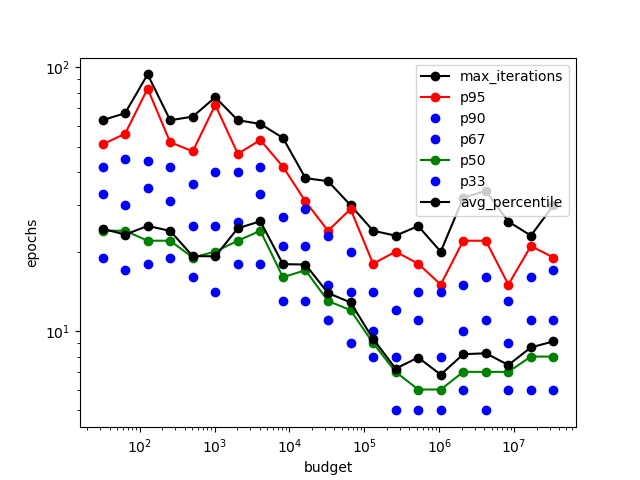

Text(0, 0.5, 'epochs')

In [13]:
dataset = 'connect_4'
filtered = df[df['config.dataset'] == dataset]
fig, ax = plt.subplots(1)
ax.plot(filtered['config.budget'], filtered['max_iterations'], 'ok-', label='max_iterations')
ax.plot(filtered['config.budget'], filtered['p95'], 'or-', label='p95')
ax.plot(filtered['config.budget'], filtered['p90'], 'ob', label='p90')
ax.plot(filtered['config.budget'], filtered['p67'], 'ob', label='p67')
ax.plot(filtered['config.budget'], filtered['p50'], 'og-', label='p50')
ax.plot(filtered['config.budget'], filtered['p33'], 'ob', label='p33')
ax.plot(filtered['config.budget'], filtered['avg_iterations'], 'o-k', label='avg_percentile')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_xlabel('budget')
ax.set_ylabel('epochs')

<IPython.core.display.Javascript object>


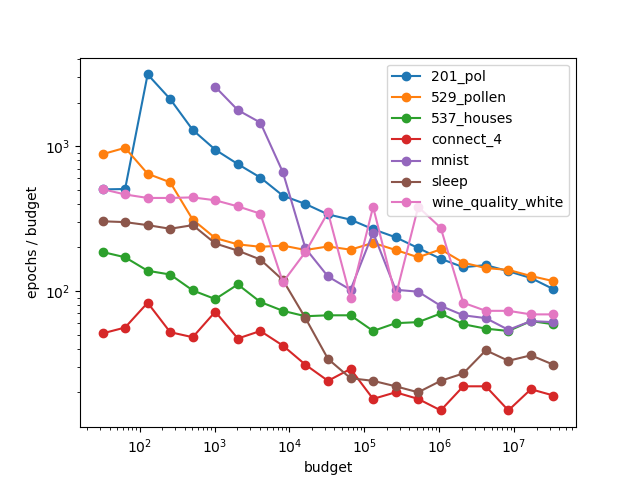

455
206
73
42
660
119
115


In [14]:
datasets = [d for d in pd.unique(df['config.dataset']) if d not in {'nursery', 'adult'}]

fig, ax = plt.subplots(1)
for dataset in datasets:
#     if dataset != '529_pollen':
#         continue
#     filtered = df[(df['config.dataset'] == dataset) & (df['config.topology'] == 'trapezoid') & (df['config.residual_mode'] == 'none')]
    filtered = df[(df['config.dataset'] == dataset)]
    budget = filtered['config.budget']
    v = filtered['p95']
#     v = np.log10(v)
#     v_min = v.min()
#     v_max = v.max()
#     v_avg = v.mean()
#     v_std = v.std()
#     v_norm = (v - v_avg) / (v_std)
#     ax.plot(budget, v, 'o-', label=dataset)
    ax.plot(budget, v, 'o-', label=dataset)
    print(filtered[filtered['config.budget'] == 8192]['p95'].iloc[0])
    
#     ax.plot(budget, budget * filtered[], 'o-', label=dataset)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('budget')
    ax.set_ylabel('epochs / budget')

In [15]:
from sklearn.linear_model import LinearRegression

for dataset in datasets:
    filtered = df[(df['config.dataset'] == dataset)]
    budget = filtered['config.budget']
    v = filtered['p95']
    x = np.log(budget)
    y = np.log(v/budget)
    X = np.reshape(x.to_numpy(), (len(x), 1))
    reg = LinearRegression().fit(X, y)
    print(f'{dataset} score: {reg.score(X, y)} coef: {reg.coef_} intercept: {reg.intercept_}')

201_pol score: 0.9924226029516098 coef: [-1.19362179] intercept: 7.950842974817022
529_pollen score: 0.9961419460769678 coef: [-1.12395313] intercept: 6.768707126612037
537_houses score: 0.9985539788252706 coef: [-1.07998381] intercept: 5.213180213125439
connect_4 score: 0.997318734115071 coef: [-1.11140072] intercept: 4.604741992826761
mnist score: 0.9824437459612909 coef: [-1.35547852] intercept: 9.536586601944183
sleep score: 0.9905921812530742 coef: [-1.21898858] intercept: 6.545592061968217
wine_quality_white score: 0.9908066504477884 coef: [-1.14709052] intercept: 6.875532030309655


<IPython.core.display.Javascript object>


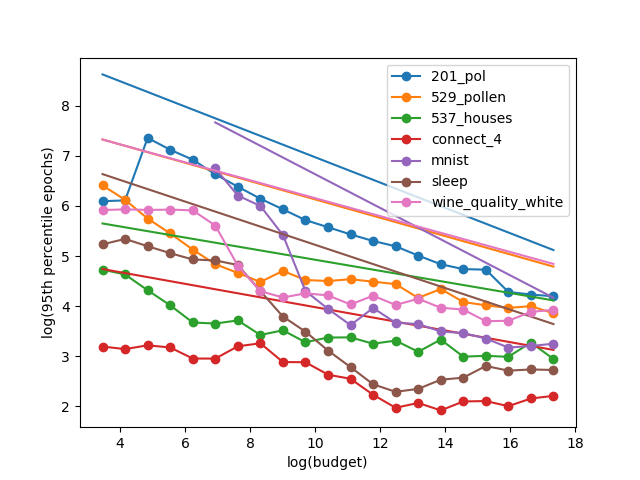

201_pol m: -0.2527556990577517 b: 9.49977870574055
529_pollen m: -0.1828880380176178 b: 7.959374801248314
537_houses m: -0.1107292366475284 b: 6.034216607966078
connect_4 m: -0.11638405390151485 b: 5.145003436644972
mnist m: -0.33632863634773813 b: 9.996732502676792
sleep m: -0.2157347864530791 b: 7.382542537374148
wine_quality_white m: -0.1789681721687238 b: 7.944812811733328


In [25]:
import scipy

def fit_above(x, y) :
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    x0, y0 = x[0] - 1, y[0]
    x -= x0
    y -= y0

    def error_function_2(b, x, y) :
        a = np.max((y - b) / x)
        return np.sum((y - a * x - b)**2)

    b = scipy.optimize.minimize(error_function_2, [0], args=(x, y)).x[0]

    a = np.max((y - b) / x)

    return a, b - a * x0 + y0

datasets = [d for d in pd.unique(df['config.dataset']) if d not in {'nursery', 'adult'}]

fig, ax = plt.subplots(1)
for dataset in datasets:
#     if dataset != '529_pollen':
#         continue
#     filtered = df[(df['config.dataset'] == dataset) & (df['config.topology'] == 'trapezoid') & (df['config.residual_mode'] == 'none')]
    filtered = df[(df['config.dataset'] == dataset)]
    budget = filtered['config.budget'].to_numpy()
    v = filtered['avg_iterations'].to_numpy()
    x = np.log(budget)
#     x = 1.0 / budget
#     y = np.log(v)
#     y = np.log(v)
    y = np.log(v)
#     v = np.log10(v)
#     v_min = v.min()
#     v_max = v.max()
#     v_avg = v.mean()
#     v_std = v.std()
#     v_norm = (v - v_avg) / (v_std)
#     ax.plot(budget, v, 'o-', label=dataset)
    p = ax.plot(x, y, 'o-', label=dataset)
    
#     X = np.reshape(x, (len(x), 1))
#     reg = LinearRegression().fit(X, y)
#     print(f'{dataset} score: {reg.score(X, y)} coef: {reg.coef_} intercept: {reg.intercept_}')
    
#     ax.plot(x, y, 'o-', label=dataset)
#     ax.plot(x, reg.coef_ * x + reg.intercept_, '-', color = p[0].get_color())
    
    m, b = fit_above(x,y)
    extra = np.log(2.5)
    b+=extra
    plt.plot(x, m*x + b, '-', color=p[0].get_color())
    print(f'{dataset} m: {m} b: {b}')
#     ax.plot(budget, budget * filtered[], 'o-', label=dataset)

#     ax.set_yscale('log')
#     ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('log(budget)')
    ax.set_ylabel('log(95th percentile epochs)')

In [ ]:
import scipy

def fit_above(x, y) :
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    x0, y0 = x[0] - 1, y[0]
    x -= x0
    y -= y0

    def error_function_2(b, x, y) :
        a = np.max((y - b) / x)
        return np.sum((y - a * x - b)**2)

    b = scipy.optimize.minimize(error_function_2, [0], args=(x, y)).x[0]

    a = np.max((y - b) / x)

    return a, b - a * x0 + y0

datasets = [d for d in pd.unique(df['config.dataset']) if d not in {'nursery', 'adult'}]

fig, ax = plt.subplots(1)
for dataset in datasets:
#     if dataset != '529_pollen':
#         continue
#     filtered = df[(df['config.dataset'] == dataset) & (df['config.topology'] == 'trapezoid') & (df['config.residual_mode'] == 'none')]
    filtered = df[(df['config.dataset'] == dataset)]
    budget = filtered['config.budget'].to_numpy()
    v = filtered['avg_iterations'].to_numpy()
    x = np.log(budget)
#     x = 1.0 / budget
#     y = np.log(v)
#     y = np.log(v)
    y = np.log(v)
#     v = np.log10(v)
#     v_min = v.min()
#     v_max = v.max()
#     v_avg = v.mean()
#     v_std = v.std()
#     v_norm = (v - v_avg) / (v_std)
#     ax.plot(budget, v, 'o-', label=dataset)
#     p = ax.plot(x, y, 'o-', label=dataset)
    
#     X = np.reshape(x, (len(x), 1))
#     reg = LinearRegression().fit(X, y)
#     print(f'{dataset} score: {reg.score(X, y)} coef: {reg.coef_} intercept: {reg.intercept_}')
    
#     ax.plot(x, y, 'o-', label=dataset)
#     ax.plot(x, reg.coef_ * x + reg.intercept_, '-', color = p[0].get_color())
    
    m, b = fit_above(x,y)
    extra = .1
    b+=extra
#     plt.plot(x, m*x + b, '-', color=p[0].get_color())
    print(f'{dataset} m: {m} b: {b}')
#     ax.plot(budget, budget * filtered[], 'o-', label=dataset)
    bound = np.ceil(np.exp(m * np.log(budget) + b))
    p = ax.plot(x, bound/v , 'o-', label=dataset)
    print(f'dataset {dataset} {bound}')
#     ax.set_yscale('log')
#     ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('budget')
    ax.set_ylabel('epochs / budget')


In [ ]:
datasets = [d for d in pd.unique(df['config.dataset']) if d not in {'nursery', 'adult'}]

fig, ax = plt.subplots(1)
for dataset in datasets:
#     if dataset != '529_pollen':
#         continue
#     filtered = df[(df['config.dataset'] == dataset) & (df['config.topology'] == 'trapezoid') & (df['config.residual_mode'] == 'none')]
    filtered = df[(df['config.dataset'] == dataset)]
    budget = filtered['config.budget']
    v = filtered['p95']
#     v = np.log10(v)
#     v_min = v.min()
#     v_max = v.max()
#     v_avg = v.mean()
#     v_std = v.std()
#     v_norm = (v - v_avg) / (v_std)
#     ax.plot(budget, v, 'o-', label=dataset)
    ax.plot(budget, v, 'o-', label=dataset)
    print(filtered[filtered['config.budget'] == 8192]['p95'].iloc[0])
    
#     ax.plot(budget, budget * filtered[], 'o-', label=dataset)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('budget')
#     ax.set_ylabel('epochs / budget')

In [ ]:
query_string = f'''
    SELECT
        MAX(iterations) as max_iterations,
        (percentile_disc(0.95) within group (order by iterations ASC)) as p95,
        (percentile_disc(0.9) within group (order by iterations ASC)) as p90,
        (percentile_disc(0.67) within group (order by iterations ASC)) as p67,
        (percentile_disc(0.5) within group (order by iterations ASC)) as p50,
        (percentile_disc(0.33) within group (order by iterations ASC)) as p33,
        AVG(iterations) as avg_percentile,
        "config.dataset",
        "config.budget",
        max("config.early_stopping.patience") as max_patience,
        min("config.early_stopping.patience") as min_patience,
        "config.topology",
        "config.residual_mode"
    FROM
        materialized_experiments_0 t
    WHERE
        "groupname" IN ('exp00','exp01','exp02','exp05','exp06')
    GROUP BY
        "config.topology",
        "config.residual_mode",
        "config.dataset",
        "config.budget"
'''

df = cached_query(query_string)
display(df.columns)
df

In [ ]:
datasets = [d for d in pd.unique(df['config.dataset']) if d not in {'nursery', 'adult'}]

styles = ['']

fig, ax = plt.subplots(1)
for dataset in datasets:
    f1 = df[df['config.dataset'] == dataset]
    for topology in pd.unique(f1['config.topology']):
        filtered = f1[f1['config.topology'] == topology]
        v = filtered['p95']
        v = np.log(v)
        v_min = v.min()
        v_max = v.max()
        v_avg = v.mean()
        v_std = v.std()
        v_norm = (v - v_avg) / (v_std)
        ax.plot(filtered['config.budget'], v_norm, 'o', label=f'{dataset} {topology}')

    #     ax.set_yscale('log')
        ax.set_xscale('log')
#         ax.legend()
        ax.set_xlabel('budget')
        ax.set_ylabel('normed epochs')